In [1]:
import sys, os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
import seaborn as sb
import torch
import wandb
import yaml
import datetime
from tqdm.notebook import tqdm

import umap
from sklearn.manifold import TSNE
from scipy import stats
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA

sys.path.append('../')
from src.dataset_large import ProtoPlanetaryDisks
from src.ae_model_phy import ConvLinTrans_AE
from src.utils import str2bool, plot_recon_wall

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

main_path = os.path.dirname(os.getcwd())
save_plots = False
%matplotlib inline


In [17]:
#ID = 'l16wuz7i' #good #treasured-sweep --batch-size=64 --cond=F --conv-blocks=4 -dropout=0.2 --feed-phy=T --img-norm=T --kernel-size=3 --latent-dim=8 --lr=1e-05 --lr-sch=exp --num-epochs=150 --optim=Adam --par-norm=T --subset=fexp1
#ID = 'oflrngm1'
#ID = '2x1fwva2' #too grainy #still-sweep--batch-size=64  --cond=F --conv-blocks=4 --dropout=0.2 --feed-phy=T --img-norm=T --kernel-size=3 --latent-dim=8 --lr=0.0001 --lr-sch=cos --num-epochs=150 --optim=Adam --par-norm=T --subset=fexp1
ID = 'e8p2lwf6' #pretty good #dashing-sweep --batch-size=64 --cond=F --conv-blocks=4 --dropout=0.2 --feed-phy=T --img-norm=T --kernel-size=3 --latent-dim=8 --lr=1e-05 --lr-sch=cos --num-epochs=150 --optim=Adam --par-norm=T --subset=fexp1
#ID = 'q3009v1x' # #giddy-sweep --batch-size=64 --cond=F --conv-blocks=4 --dropout=0.2 --feed-phy=T --img-norm=T --kernel-size=3 --latent-dim=8 --lr=1e-05 --lr-sch=plateau --num-epochs=150 --optim=Adam --par-norm=T --subset=fexp1

gpu = True
rnd_seed = 13
device = torch.device("cuda:0" if torch.cuda.is_available() and gpu else "cpu")
cmap = 'viridis_r'
image_norm = 'global'

In [18]:
def load_model_list(ID='zg3r4orb', device='cpu'):
    
    fname = glob.glob('%s/wandb/run-*-%s/model.pt' % 
                      (main_path, ID))[0]
    
    config_f = glob.glob('%s/wandb/run-*-%s/config.yaml' % 
                         (main_path, ID))[0]
    with open(config_f, 'r') as f:
        conf = yaml.safe_load(f)
    conf = {k: v['value'] for k,v in conf.items() if 'wandb' not in k}
    aux = re.findall('\/run-(\d+\_\d+?)-\S+\/', config_f)
    conf['date'] = aux[0] if len(aux) != 0 else ''
    del aux
    conf['ID'] = ID
    
    print('Loading from... \n', fname)
    
    model = ConvLinTrans_AE(latent_dim=conf['latent_dim'],
                            img_dim=187,
                            in_ch=1,
                            dropout=conf['dropout'],
                            kernel=conf['kernel_size'],
                            n_conv_blocks=conf['conv_blocks'],
                            phy_dim=conf['physics_dim'],
                            feed_phy=str2bool(conf['feed_phy']))
        
    state_dict = torch.load(fname, map_location=device)
    if list(state_dict.keys())[0].split('.')[0] == 'module':
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
    else:
        new_state_dict = state_dict
    model.load_state_dict(new_state_dict)
    model.eval()
    model.to(device)
    print('Is model in cuda? ', next(model.parameters()).is_cuda)
    
    return model, conf


def evaluate_encoder(model, dataloader, conf, 
                     force=False, device='cpu'):
    
    fname_z = '%s/wandb/run--%s/latent_space_z.txt' % (main_path, conf['ID'])

    if os.path.exists(fname_z) & ~force:
        print('Loading from files...')
        z = np.loadtxt(fname_z)
    
    else:
        print('Evaluating Encoder...')
        time_start = datetime.datetime.now()
        
        z_all, meta, imgs = [], [], []
        with tqdm(total=len(dataloader)) as pbar:
            for i, (img, par) in enumerate(dataloader):
                img = img.to(device)
                par = par.to(device)
                if conf['physics_dim'] > 0:
                    z = model.encode(img, phy=par)
                else:
                    z = model.encode(img)
                z_all.extend(z.data.cpu().numpy())
                meta.append(par.data.cpu().numpy())
                imgs.append(img.data.cpu().numpy())
                torch.cuda.empty_cache()
                pbar.update()

        z_all = np.array(z_all)
        meta = np.concatenate(meta, axis=0)
        imgs = np.concatenate(imgs, axis=0)

        #np.savetxt(fname_mu, mu)
        #np.savetxt(fname_std, std)
        #np.savetxt(fname_lbs, np.asarray(labels), fmt='%s')
        elap_time = datetime.datetime.now() - time_start
        print('Elapsed time  : %.2f s' % (elap_time.seconds))
        print('##'*20)
        
    z_df = pd.DataFrame(z_all)
    
    return z_df, meta, imgs


def evaluate_autoencoder(model, dataloader, conf, 
                         force=False, device='cpu'):
    
    fname_z = '%s/wandb/run--%s/latent_space_z.txt' % (main_path, conf['ID'])

    if os.path.exists(fname_z) & ~force:
        print('Loading from files...')
        z = np.loadtxt(fname_z)
    
    else:
        print('Evaluating Encoder...')
        time_start = datetime.datetime.now()
        
        z_all, meta, imgs, reco = [], [], [], []
        with tqdm(total=len(dataloader)) as pbar:
            for i, (img, par) in enumerate(dataloader):
                img = img.to(device)
                par = par.to(device)
                if conf['physics_dim'] > 0:
                    rec, z = model(img, phy=par)
                else:
                    rec, z = model(img)
                z_all.extend(z.data.cpu().numpy())
                meta.append(par.data.cpu().numpy())
                imgs.append(img.data.cpu().numpy())
                reco.append(rec.data.cpu().numpy())
                torch.cuda.empty_cache()
                pbar.update()

        z_all = np.array(z_all)
        meta = np.concatenate(meta, axis=0)
        imgs = np.concatenate(imgs, axis=0)
        reco = np.concatenate(reco, axis=0)

        #np.savetxt(fname_mu, mu)
        #np.savetxt(fname_std, std)
        #np.savetxt(fname_lbs, np.asarray(labels), fmt='%s')
        elap_time = datetime.datetime.now() - time_start
        print('Elapsed time  : %.2f s' % (elap_time.seconds))
        print('##'*20)
        
    z_df = pd.DataFrame(z_all)
    
    return z_df, reco, meta, imgs


def give_me_latent(ID='4kb62bfn', device='cpu', rnd_seed=rnd_seed, force=True):
    
    ## Download run files from WB
    if not os.path.exists('%s/wandb/run--%s/model.pt' % 
                      (main_path, ID)):
        print('Downloading files from Weight & Biases')
    
        api = wandb.Api()
        run = api.run('deep_ppd/PPD-AE/%s' % (ID))
        run.file('model.pt').download(replace=True, 
                                  root='%s/wandb/run--%s/' % 
                                  (main_path, ID))
        run.file('config.yaml').download(replace=True, 
                                     root='%s/wandb/run--%s/' % 
                                     (main_path, ID))
    
    ## load model and params
    model, config = load_model_list(ID=ID, device=device)
    for key, value in config.items():
        print('%15s\t: %s' % (key, value))
    
    ## load data and data loaders
    if  config['img_norm'] in ['T', 'F']:
        image_norm = 'global'
    else:
        image_norm = config['image_norm']
    print('image_norm: ', image_norm)
    dataset = ProtoPlanetaryDisks(machine='exalearn', 
                                  transform=False, 
                                  par_norm=True,
                                  subset=config['subset'],
                                  image_norm=image_norm)
    print('Dataset length: ', len(dataset))
    train_loader, val_loader, test_loader = dataset.get_dataloader(batch_size=128,
                                                               shuffle=True,
                                                               val_split=.2,
                                                               random_seed=rnd_seed)
    
    ## evaluate encoder and save latent code
    z, pp, imgs = evaluate_encoder(model, val_loader, config, 
                                   force=force, device=device)
    if config['par_norm'] == 'T':
        pp = dataset.MinMaxSc.inverse_transform(pp)
    
    return z, pp, imgs, dataset, model, config, (train_loader, val_loader, test_loader)

In [19]:
z, pp, imgs, dataset, model, config, loaders = give_me_latent(ID=ID, device=device)

Loading from... 
 /home/jorgemarpa/Astro/PPDAE/wandb/run--e8p2lwf6/model.pt
Is model in cuda?  True
     batch-size	: 64
     batch_size	: 64
        comment	: hyperparams_sweep
           cond	: F
    conv-blocks	: 4
    conv_blocks	: 4
           data	: PPD
        dropout	: 0.2
        dry_run	: False
     early_stop	: False
       feed-phy	: T
       feed_phy	: F
       img-norm	: T
       img_norm	: T
    kernel-size	: 3
    kernel_size	: 3
     latent-dim	: 8
     latent_dim	: 8
             lr	: 1e-05
         lr-sch	: cos
         lr_sch	: cos
        machine	: exalearn
     model-name	: ConvLinTrans_AE
     model_name	: ConvLinTrans_AE
 n_train_params	: 4613647
     num-epochs	: 150
     num_epochs	: 150
          optim	: Adam
       par-norm	: T
       par_norm	: T
    physics_dim	: 0
       rnd_seed	: 13
         subset	: fexp1
           date	: 
             ID	: e8p2lwf6
image_norm:  global
Dataset length:  70630
Evaluating Encoder...



Elapsed time  : 8.00 s
########################################


In [20]:
model, config = load_model_list(ID=ID, device=device)
model_cpu, config_cpu = load_model_list(ID=ID, device='cpu')

Loading from... 
 /home/jorgemarpa/Astro/PPDAE/wandb/run--e8p2lwf6/model.pt
Is model in cuda?  True
Loading from... 
 /home/jorgemarpa/Astro/PPDAE/wandb/run--e8p2lwf6/model.pt
Is model in cuda?  False


# Linear Regression

In [21]:
#Now we want to train our linear regressor given the physical parameters and
#the latent space parameters of the chosen model

pp_new = pp.copy()

pp_new[:,0] = np.log10(pp[:,0])
pp_new[:,1] = np.log10(pp[:,1])
pp_new[:,4] = np.log10(pp[:,4])
pp_new[:,6] = np.log10(pp[:,6])

X = np.array(pp_new[:,0:8]) #physical parameters
y = np.array(z) #latent space

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0) #split into train and test data
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm
print("R-squared Score:")
regressor.score(X_test, y_test)

R-squared Score:


0.5065841889929279

In [22]:
test_params = np.load("MCFOST_test_params.npy") #physical parameters corresponding to test set
test_imgs = np.load("MCFOST_test_imgs.npy") #set of test images generated w/ MCFOST for comparison

test_params[:,0] = np.log10(test_params[:,0])
test_params[:,1] = np.log10(test_params[:,1])
test_params[:,4] = np.log10(test_params[:,4])
test_params[:,6] = np.log10(test_params[:,6])

In [23]:
time_start = datetime.datetime.now()
y_pred = regressor.predict(test_params) #use regressor to predict latent space vals from test parameters
z_test = np.array(y_pred) #array of predicted latent space values
z_test_float= torch.from_numpy(z_test).float() #convert to float array, make it a pytorch array
z_test_gpu = z_test_float.to(device=device) #send to GPU
x = model.decode(z_test_gpu) #predicted image from latent space values using ML decoder
x = x.to(device='cpu') #send to CPU
x = x.detach().numpy() 
elap_time = datetime.datetime.now() - time_start
print(elap_time/len(x), "per image on averge")


0:00:00.000462 per image on averge


2


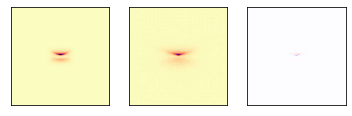

3


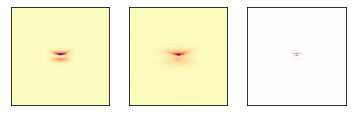

4


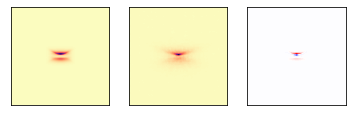

5


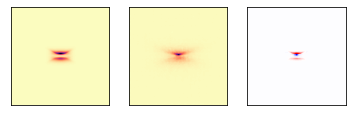

6


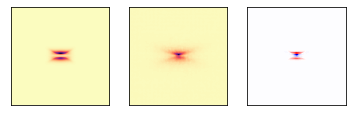

7


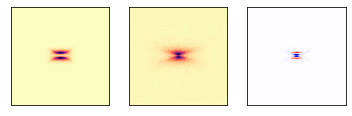

8


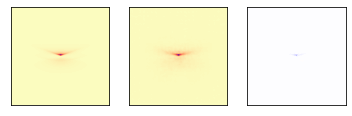

9


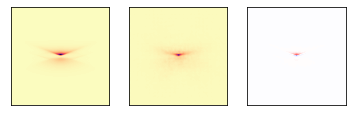

10


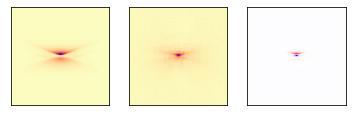

11


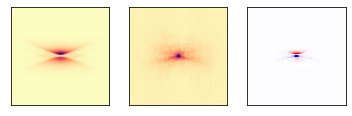

12


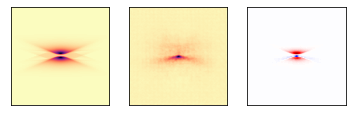

13


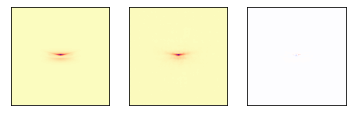

14


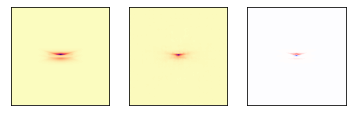

15


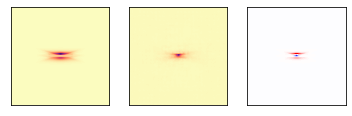

16


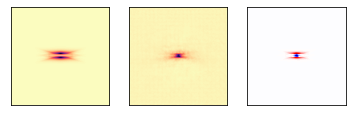

17


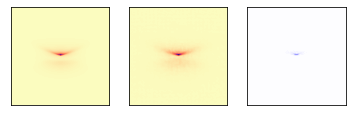

18


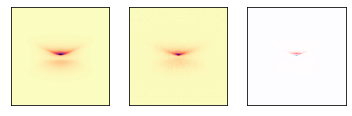

19


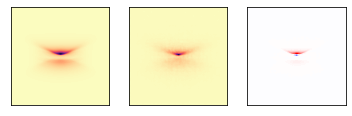

20


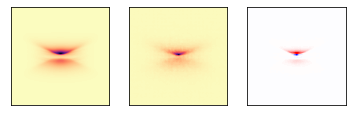

21


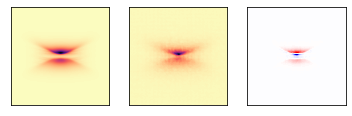

22


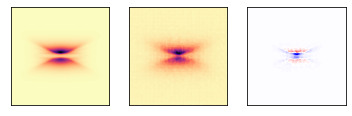

23


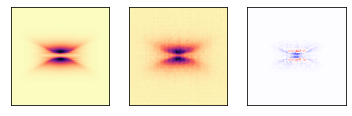

24


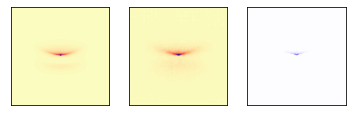

25


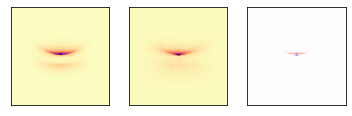

26


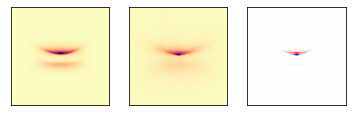

27


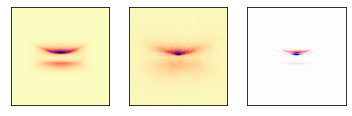

28


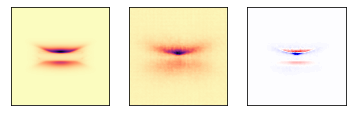

29


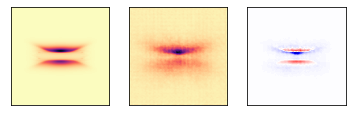

30


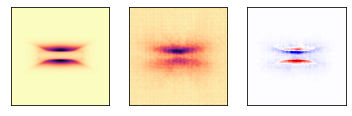

31


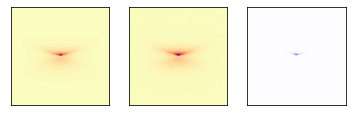

32


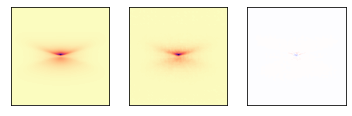

33


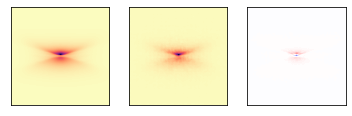

34


KeyboardInterrupt: 

In [24]:
for i in range(2, len(x)):
    
    print(i)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    ax1.imshow(np.sqrt(test_imgs[i]/np.max(test_imgs[i])), vmin=0, vmax=1, origin='lower', cmap='magma_r')#,norm=SymLogNorm(linthresh=1e-2, vmin=0,vmax=1),origin='lower')
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax2.imshow(np.sqrt(x[i,0,:,:]/np.max(x[i,0,:,:])), vmin=0, vmax=1, origin='lower', cmap='magma_r')#, norm=SymLogNorm(linthresh=1e-2, vmin=0,vmax=1),origin='lower')
    ax2.set_xticks([])
    ax2.set_yticks([])  
    
    res = test_imgs[i]/np.max(test_imgs[i]) - x[i,0,:,:]/np.max(x[i,0,:,:])
    
    ax3.imshow(res, vmin=-1, vmax=1, origin='lower', cmap='seismic')
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    plt.show()

In [ ]:
#x = x[:,0,:,:] #index to get correct shape
#np.save('ML_imgs_batch1.npy', x) #save ML images

# Random Forest Regression

In [8]:
from sklearn.ensemble import RandomForestRegressor

In [9]:
RandomForestRegModel = RandomForestRegressor()
RandomForestRegModel.fit(X_train, y_train)
print("R-squared Score:")
RandomForestRegModel.score(X_test, y_test)

R-squared Score:


0.9056535264553195

# Time image generation

In [142]:
#test time using GPU

def gen_img_GPU(params): #generates expected image from parameter array
    z_test = RandomForestRegModel.predict(params)
    z_test_float= torch.from_numpy(z_test).float() #convert to float array, make it a pytorch array
    z_test_gpu = z_test_float.to(device=device) #send to GPU (make sure device is GPU)
    x = model.decode(z_test_gpu) #predicted image from latent space values using ML decoder
    x = x.to(device='cpu') #send to CPU
    x = (x.detach().numpy())
    return x

%timeit x_cpu = gen_img_GPU(test_params)

127 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [143]:
print(.128/len(test_params), "seconds/image on average on GPU")

0.00045390070921985816 seconds/image on average on GPU


In [122]:
#test time using CPU

def gen_img_CPU(params): #generates expected image from parameter array
    z_test = RandomForestRegModel.predict(params)
    z_test_float = torch.from_numpy(z_test).float() #convert to float array, make it a pytorch array
    x = model_cpu.decode(z_test_float) #predicted image from latent space values using ML decoder
    x = (x.detach().numpy())
    return x

%timeit x_cpu = gen_img_CPU(test_params)

14.9 s ± 3.88 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [129]:
print(14.9/len(test_params), "seconds/image on average on CPU")

0.05283687943262411 seconds/image on average on CPU


In [130]:
for i in range(10):
    %timeit gen_img_GPU([test_params[i]])

10.5 ms ± 686 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.33 ms ± 495 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.33 ms ± 695 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.6 ms ± 838 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.1 ms ± 491 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.5 ms ± 843 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.1 ms ± 620 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.4 ms ± 621 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.7 ms ± 83.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.9 ms ± 763 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
for i in range(10):
    %timeit gen_img_CPU([test_params[i]])

# Generate ML RFR Images

In [10]:
y_pred = RandomForestRegModel.predict(test_params)
z_test = np.array(y_pred) #array of predicted latent space values
z_test_float= torch.from_numpy(z_test).float() #convert to float array, make it a pytorch array
z_test_gpu = z_test_float.to(device=device) #send to GPU
x = model.decode(z_test_gpu) #predicted image from latent space values using ML decoder
x = x.to(device='cpu') #send to CPU
x = x.detach().numpy()

2


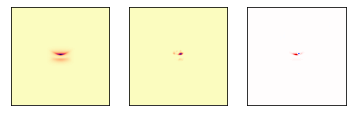

3


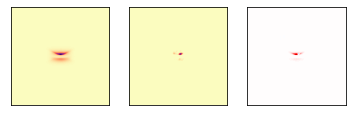

4


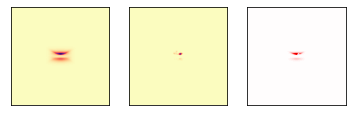

5


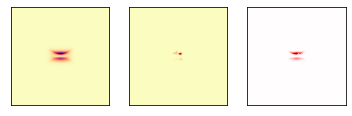

6


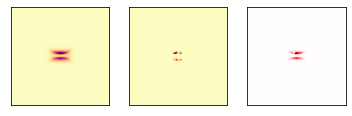

7


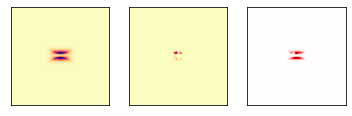

8


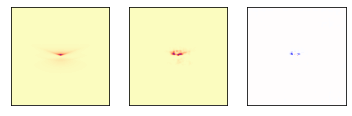

9


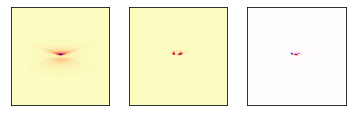

In [12]:
#Plot test MCFOST images, corresponding ML images, residuals

for i in range(2, len(x)):
    
    print(i)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    ax1.imshow(np.sqrt(test_imgs[i]/np.max(test_imgs[i])), vmin=0, vmax=1, origin='lower', cmap='magma_r')#,norm=SymLogNorm(linthresh=1e-2, vmin=0,vmax=1),origin='lower')
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax2.imshow(np.sqrt(x[i,0,:,:]/np.max(x[i,0,:,:])), vmin=0, vmax=1, origin='lower', cmap='magma_r')#, norm=SymLogNorm(linthresh=1e-2, vmin=0,vmax=1),origin='lower')
    ax2.set_xticks([])
    ax2.set_yticks([])  
    
    res = test_imgs[i]/np.max(test_imgs[i]) - x[i,0,:,:]/np.max(x[i,0,:,:])
    
    ax3.imshow(res, vmin=-1, vmax=1, origin='lower', cmap='seismic')
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    plt.show()

In [244]:
#x = x[:,0,:,:] #index to get correct shape
#np.save('ML_imgs_RFR_batch1.npy', x) #save ML images

# Slider Widget

In [68]:
def gen_img(log_mdust, log_Rc, f_exp, H0, log_Rin, sd_exp, log_amax, inc):
    test_pred = RandomForestRegModel.predict([[log_mdust, log_Rc, f_exp, H0, log_Rin, sd_exp, log_amax, inc]])
    z_test = np.array(test_pred) #array of predicted latent space values
    z_test_float= torch.from_numpy(z_test).float() #convert to float array, make it a pytorch array
    z_test_gpu = z_test_float.to(device=device) #send to GPU
    x = model.decode(z_test_gpu) #predicted image from latent space values using ML decoder
    x = x.to(device='cpu') #send to CPU
    x = x.detach().numpy() 
    plt.imshow(np.sqrt(x[0,0,:,:]), origin='lower')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [69]:
cmb_w = interact(gen_img, log_mdust = (-7,-3), log_Rc=(1,2.477,0.1), f_exp=(1,1.3,0.01), H0=(5,20,1), log_Rin=(-1,1,0.1), sd_exp=(-1.5,0,0.1), log_amax=(1,4,0.1),  inc = (70,90,1))


A Jupyter Widget

# Residual Plots

In [23]:
def plot_recon_wall(xhat, x, cmap):
    
    """
    ----------
    xhat : numpy array
        Array of generated imgs
    x    : numpy array
        List of real imgs.
    epoch: int, optional
        Epoch number

    Returns
    -------
    fig
        a matplotlib figure
    image
        an image version of the figure
    """

    plt.close('all')
    ncols = 5
    fig, axis = plt.subplots(nrows=3, ncols=ncols, figsize=(ncols, 4))
    
    #nums = np.random.randint(0,len(x),ncols)
    #print(nums)
    nums = [231, 258, 278, 226, 154, 191,]
    
    for i in range(ncols):
        
        axis[0, i].imshow(np.sqrt(test_imgs[nums[i]]/np.max(test_imgs[nums[i]])), vmin=0, vmax=1, interpolation='bilinear',
                  cmap=cmap, origin='lower', aspect='equal')

        axis[1, i].imshow(np.sqrt(x[nums[i],0,:,:]/np.max(x[nums[i],0,:,:])), vmin=0, vmax=1, interpolation='bilinear',
                          cmap=cmap, origin='lower', aspect='equal')
        
        res = test_imgs[nums[i]]/np.max(test_imgs[nums[i]]) - x[nums[i],0,:,:]/np.max(x[nums[i],0,:,:]) #MCFOST - ML
        
        
        axis[2, i].imshow(res, vmin=-1, vmax=1,
                          interpolation='bilinear',
                          cmap=cm.seismic, origin='lower', aspect='equal')#, norm = colors.SymLogNorm(linthresh=.0005, linscale=100, 
                                     #vmin=-np.max(res), vmax=np.max(res)))

    for ax in axis.ravel():
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1)
    #fig.suptitle('Reconstruction [Epoch %s]' % epoch,
                 #fontsize=20, y=.95)
    fig.canvas.draw()
    #return fig


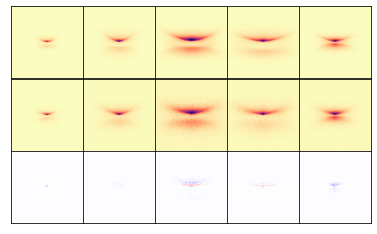

In [24]:
plot_recon_wall(test_imgs, x, 'magma_r')

[106  13 148 146 268]


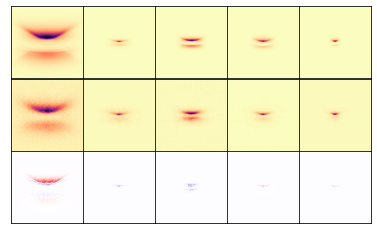

In [22]:
plot_recon_wall(test_imgs, x, 'magma_r')